In [93]:
import pickle
import numpy as np

In [94]:
def load(path):
    with open(path, "rb") as fp:   # Unpickling
        sql_predict = np.array(pickle.load(fp))
    return sql_predict

In [95]:
arr_results = []
for i in range(80):
    path = f"/data/home/vkropoti/sql_llm_answers/bird_train_m_schema/sql_results_Qwen3-1.7B-reasoning-v{i}"
    arr_results.append(load(path))

In [96]:
arr_results = np.stack(arr_results)

In [97]:
arr_results.shape

(80, 9428)

In [98]:
np.mean(np.max(arr_results,axis=0))

0.6651463725074247

## Собираем индексы

In [99]:
indices = []
values = []
for i in range(arr_results.shape[1]):  # Итерируемся по каждой позиции (1500)
    column = arr_results[:, i]  # Получаем столбец для текущей позиции
    ones = np.arange(len(column))[column == 1]  # Выбираем все единицы
    zeros = np.arange(len(column))[column == 0]  # Выбираем все нули
    
    
    
    # Формируем три значения: сначала единицы, затем нули, если необходимо
    selected = list(np.random.permutation(ones)[:5])  # Берём первые три единицы
    needed = 5 - len(selected)
    if needed > 0:
        selected += list(zeros[:needed])  # Добавляем нужное количество нулей
    
    indices.append(selected)
    
    ones = column[column == 1]  # Выбираем все единицы
    zeros = column[column == 0]  # Выбираем все нули
    selected = list(ones[:5])  # Берём первые три единицы
    needed = 5 - len(selected)
    if needed > 0:
        selected += list(zeros[:needed])
        
    values.append(selected)
# Преобразуем результат в NumPy-массив
indices = np.array(indices)
values = np.array(values)

In [100]:
np.mean(np.min(indices,axis=1))

7.374840899448452

In [101]:
np.mean(np.min(values,axis=1))

0.595566397963513

In [103]:
indices_good

array([[ 0,  1,  2,  3,  4],
       [66, 54,  6, 69, 11],
       [ 0,  1,  2,  3,  4],
       ...,
       [76, 72, 29, 38, 20],
       [19, 28, 20,  9, 16],
       [22,  8, 77, 23, 47]])

In [104]:
values

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [102]:
indices_good = indices.copy()
values_good = values.copy()

In [38]:
%%time
path = f"/data/home/vkropoti/sql_llm_answers/bird_train_m_schema/sql_all_Qwen3-1.7B-reasoning-v{0}"
answer = load(path)

CPU times: user 68.3 ms, sys: 375 ms, total: 443 ms
Wall time: 444 ms


In [34]:
from transformers import AutoTokenizer

/data/home/vkropoti/vllm/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
tokenizer = AutoTokenizer.from_pretrained(f"/data/home/vkropoti/models/Qwen3-1.7B")

In [37]:
print(tokenizer.apply_chat_template([
                {"role": "user", "content": "тут будет входящий промпт"},
                {"role": "assistant", "content": answer[0]}
            ], add_generation_prompt = False, tokenize = False))

<|im_start|>user
тут будет входящий промпт<|im_end|>
<|im_start|>assistant
<think>
Okay, let's tackle this problem. The user wants to find movie titles released in 1945 and sort them by descending popularity. 

First, I need to look at the tables provided. The relevant table here is the 'movies' table because it contains the movie_release_year and movie_popularity columns. 

The 'movies' table has columns like movie_id, movie_title, movie_release_year, and movie_popularity. So, the main steps are to select the movie_title from movies where movie_release_year is 1945, and then order the results by movie_popularity in descending order.

I should check if there are any foreign keys or joins needed. But since the question is directly about the movies table, there's no need for joins. The 'ratings' and 'ratings_users' tables might have some data, but the question isn't asking about ratings. 

Wait, the user specified to use only the initial column names and not change them. So the columns i

In [ ]:
sequences = [tokenizer.apply_chat_template([
                {"role": "user", "content": "тут будет входящий промпт"},
                {"role": "assistant", "content": answer[0]}
            ], add_generation_prompt = False, tokenize = False) for data in tqdm(dataset)]

## creating dataset

In [105]:
system_prompt = """
You are a data science expert. Below, you are provided with a database schema and a natural language question. Your task is to understand the schema and generate a valid SQL query to answer the question.

Database Engine: SQLite

Firstly think how to solve the problem, analyze tables, take care what columns avaliable in each table and so on, check the syntacsis (do not otherthink 2k words is a limit, no more!).
Secondly, create the answer based on thoughts. The answer should be only sql query.

Carefully follow the instruction and add <|im_end|> and the end of the final answer.
"""

In [106]:
import os, sys
sys.path.append("/home/vkropoti/vllm")
import json
from tqdm import tqdm

In [107]:
from src.prompt import generate_combined_prompts_one
from src.prompt_reasoning import generate_combined_prompts_one as generate_combined_prompts_one_reasoning
from src.prompt_with_cot_add import generate_combined_prompts_one as generate_combined_prompts_one_with_cot

In [108]:
path_dev_json = '/data/home/vkropoti/sql_data/train/train.json'
path_sql_dbs = "/data/home/vkropoti/sql_data/train/train_databases/"

In [109]:
def load_json(dir):
    with open(dir, "r") as j:
        contents = json.loads(j.read())
    return contents

In [110]:
d_user = {}
data = load_json(path_dev_json)
batch_messages = []
for i,k in tqdm(enumerate(range(len(data)))):
# for i,k in enumerate(mini_dev_index):
    question = data[k]['question']
    db = data[k]['db_id']
    sql_dialect = "SQLite"
    knowledge = data[k]['evidence']
    prompt = generate_combined_prompts_one_reasoning(f'{path_sql_dbs}{db}/{db}.sqlite', question, sql_dialect, knowledge)
    d_user[i] = prompt
    # if paths_to_cot is not None:
    #     cots = [x[i] for x in cot]
    #     prompt = generate_combined_prompts_one_with_cot(f'{path_sql_dbs}{db}/{db}.sqlite', question, sql_dialect, cots, knowledge, use_reasoning)
    # else:
    #     if use_reasoning:
    #         prompt = generate_combined_prompts_one_reasoning(f'{path_sql_dbs}{db}/{db}.sqlite', question, sql_dialect, knowledge)
    #     else:
    #         prompt = generate_combined_prompts_one(f'{path_sql_dbs}{db}/{db}.sqlite', question, sql_dialect, knowledge)

9428it [00:00, 222742.37it/s]


In [111]:
len(d_user)

9428

In [112]:
from collections import defaultdict

In [113]:
d_base = defaultdict(list)
for iter_ in range(80):
    for i in range(indices_good.shape[1]):
        add_index = np.arange(indices_good.shape[0])[indices_good[:,i]==iter_]
        d_base[iter_].extend(list(add_index))
    d_base[iter_] = list(map(int,list(set(d_base[iter_]))))
    

In [114]:
data_answers = dict()
for iter_ in tqdm(range(80)):
    path = f"/data/home/vkropoti/sql_llm_answers/bird_train_m_schema/sql_all_Qwen3-1.7B-reasoning-v{iter_}"
    answer = load(path)
    for ind in d_base[iter_]:
        data_answers[(iter_,ind)] = answer[ind]

100%|██████████| 80/80 [02:41<00:00,  2.02s/it]


In [115]:
## creating dataset

In [116]:
arr_dataset = []
arr_values = []
arr_lens = []
for i in tqdm(range(indices_good.shape[0])):
    for j in range(indices_good.shape[1]):
        ind = int(indices_good[i,j])
        if values_good[i,j]==1:
            arr_dataset.append({"system":system_prompt,"user":d_user[i],"answer":data_answers[(ind,i)]})
        arr_values.append(values_good[i,j])
        arr_lens.append(len(system_prompt+d_user[i]+data_answers[(ind,i)]))

100%|██████████| 9428/9428 [00:00<00:00, 20871.44it/s]


In [118]:
len(arr_dataset)

29428

In [91]:
list(arr_dataset[0])

['system', 'user', 'answer']

In [92]:
print(arr_dataset[0]['user'])

here is avaliable tables and their structure below
【DB_ID】 movie_platform
【Schema】
# Table: lists
[
(user_id:INTEGER, maps to lists_users.user_id, Examples: [88260493, 45204418, 48905025]),
(list_id:INTEGER, Primary Key, Examples: [1, 2, 3]),
(list_title:TEXT, Examples: [Films that made your kid sister cry]),
(list_movie_number:INTEGER, Examples: [5, 3, 7]),
(list_update_timestamp_utc:TEXT, Examples: [2019-01-24 19:16:18, 2018-12-03 15:12:20, 2019-05-30 03:00:07]),
(list_creation_timestamp_utc:TEXT, Examples: [2009-11-11 00:02:21, 2009-11-11 00:05:11, 2009-11-11 00:20:00]),
(list_followers:INTEGER, Examples: [5, 1, 6]),
(list_url:TEXT),
(list_comments:INTEGER, Examples: [3, 2, 5]),
(list_description:TEXT),
(list_cover_image_url:TEXT),
(list_first_image_url:TEXT),
(list_second_image_url:TEXT),
(list_third_image_url:TEXT)
]
# Table: lists_users
[
(user_id:INTEGER, maps to lists.user_id, Primary Key, Examples: [2385, 15264, 15344]),
(list_id:INTEGER, maps to lists.list_id, Primary Key, Ex

In [85]:
arr_values[0:20]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [86]:
np.mean(np.array(arr_lens)<30000)

0.9479635129401782

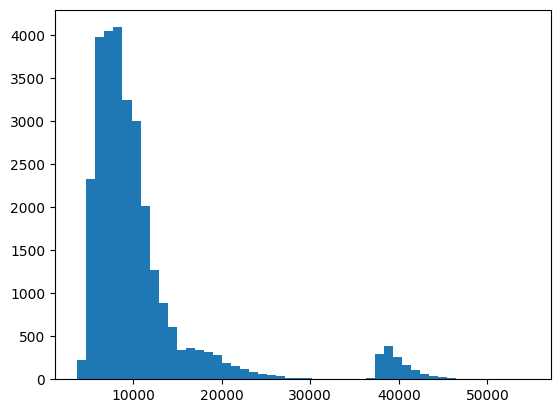

In [87]:
p = plt.hist(np.array(arr_lens)[np.array(arr_values)==1],bins=50)

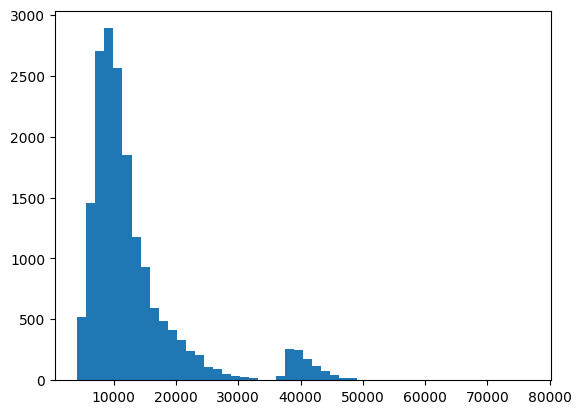

In [88]:
p = plt.hist(np.array(arr_lens)[np.array(arr_values)==0],bins=50)

In [59]:
arr_lens[0:20]

[7334,
 7115,
 7155,
 8870,
 8520,
 10548,
 8549,
 8020,
 8702,
 10439,
 8418,
 11319,
 12443,
 9945,
 10186,
 7961,
 7802,
 7557,
 10677,
 12058]

In [80]:
len(arr_dataset)

28284

In [89]:
with open("/data/home/vkropoti/sql_data/train/train_dataset_sft", "wb") as fp:   #Pickling
        pickle.dump(arr_dataset, fp)

In [120]:
with open("/data/home/vkropoti/sql_data/train/train_dataset_sft_v2", "wb") as fp:   #Pickling
        pickle.dump(arr_dataset, fp)

### проверяем как загружается

In [16]:
import os, sys
sys.path.append("/home/vkropoti/vllm")
sys.path.append("/home/vkropoti/vllm/src/utils")
import json
from tqdm import tqdm

In [17]:
from transformers import AutoTokenizer

/data/home/vkropoti/vllm/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
tokenizer = AutoTokenizer.from_pretrained(f"/data/home/vkropoti/models/Qwen3-1.7B")

In [19]:
from load_sft_dataset import SFTDataset

In [20]:
%%time
dataset = SFTDataset("/data/home/vkropoti/sql_data/train/train_dataset_sft",tokenizer,19000,'sft')

100%|██████████| 28284/28284 [00:03<00:00, 7797.93it/s]


input_ids 18698
There are 0 sequences have been truncated.
CPU times: user 59min 28s, sys: 30.1 s, total: 59min 58s
Wall time: 3min 3s


In [28]:
arr_len = []
for i in tqdm(range(len(dataset))):
    arr_len.append(max(np.arange(len(dataset[i]['attention_mask']))[dataset[i]['attention_mask'].numpy()==1]))

100%|██████████| 28284/28284 [00:06<00:00, 4569.16it/s]


In [60]:
import matplotlib.pyplot as plt

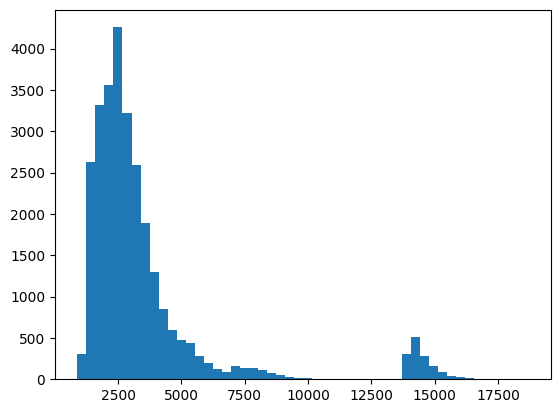

In [33]:
p = plt.hist(arr_len,bins=50)

In [27]:
max(np.arange(len(dataset[0]['attention_mask']))[dataset[0]['attention_mask'].numpy()==1])

2183

In [7]:
tokenizer.encode("<|im_start|>assistant")

[151644, 77091]

In [1]:
from monkey_patch_packing import monkey_patch_packing_for_model

ModuleNotFoundError: No module named 'monkey_patch_packing'

In [65]:
884*25/60/60

6.138888888888888